In [903]:
# import zakladnych kniznic
import numpy as np
import pandas as pd

import operator
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [904]:
# nacitanie suborov
df_train = pd.read_csv("E:/Skola/PycharmProjects/nn_covid-19_predictions/data/models/c19-week-4/train.csv", parse_dates=['Date'])
df_test = pd.read_csv("E:/Skola/PycharmProjects/nn_covid-19_predictions/data/models/c19-week-4/test.csv", parse_dates=['Date'])

In [905]:
# vypis hlaviciek a opisov datasetov
df_train.head()
df_train.describe()
df_train.info()

df_test.head()
df_train.describe()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27231 entries, 0 to 27230
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              27231 non-null  int64         
 1   Province_State  11571 non-null  object        
 2   Country_Region  27231 non-null  object        
 3   Date            27231 non-null  datetime64[ns]
 4   ConfirmedCases  27231 non-null  float64       
 5   Fatalities      27231 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13459 entries, 0 to 13458
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ForecastId      13459 non-null  int64         
 1   Province_State  5719 non-null   object        
 2   Country_Region  13459 non-null  object        
 3   Date            13459 

In [906]:
# teraz berieme policko Date ako String, preto ho preformatujem na Datetime format
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%Y-%m-%d')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%Y-%m-%d')

# a teraz ho uz vieme citat ako datum

In [907]:
# vypis najstarsieho datumu a najnovsieho datumu z trenovacej mnoziny
train_date_min = df_train['Date'].min()
train_date_max = df_train['Date'].max()
print('Najstarší dátum z trénovacej množiny: {}'.format(train_date_min))
print('Najnovší dátum z trénovacej množiny: {}'.format(train_date_max))

Najstarší dátum z trénovacej množiny: 2020-01-22 00:00:00
Najnovší dátum z trénovacej množiny: 2020-04-17 00:00:00


In [908]:
# to iste pre testovaciu mnozinu
test_date_min = df_test['Date'].min()
test_date_max = df_test['Date'].max()
print('Najstarší dátum z testovacej množiny: {}'.format(test_date_min))
print('Najnovší dátum z testovacej množiny: {}'.format(test_date_max))

Najstarší dátum z testovacej množiny: 2020-04-02 00:00:00
Najnovší dátum z testovacej množiny: 2020-05-14 00:00:00


# Predikcia nových nakazení

In [909]:
df_train.head()
x_train = df_train[[]]

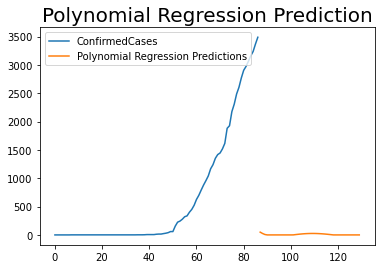

In [910]:
# Pre predikciu novych pripadov vyuzijem Linearnu regresiu
# Pridala som import sklearn
for country in df_train['Country_Region'].unique():
    degree = 5
    # print('Robim model pre krajinu: {}'.format(country))
    df_train_country = df_train[df_train['Country_Region'] == country]
    df_test_country = df_test[df_test['Country_Region'] == country]
    
    # zaujima ma, ci ma krajina provinciu, ak ano -> vetva else
    if df_train_country['Province_State'].isna().unique().any():
        # indexujem krajiny v csv subore - od a do
        x_train = np.array(range(len(df_train_country))).reshape((-1, 1))
        #print(x_train)
        y_train = df_train_country['ConfirmedCases']
        # print(y_train)
        
        # ucenie siete
        model = Pipeline([('poly', PolynomialFeatures(degree=degree, include_bias=True)), ('linear', LinearRegression(fit_intercept=False))])
        model.fit(x_train, y_train)
        
        # zacnem indexovat dni od 0
        x_test = np.array(range(len(df_test_country))).reshape((-1, 1))
        prediction = model.predict(x_test)
        
        # negativne pripady nahradim nulou
        prediction[prediction < 0] = 0
        
        # Vramci ConfirmedCases pridam sa novy stlpec v dataframe df_test kam vlozim predikciu k danej krajine
        df_test.loc[df_test['Country_Region'] == country, 'ConfirmedCases'] = prediction
       
        # print(df_test['ConfirmedCases'].astype('int'))
        
        if(country == "Finland"):
             # Visualising the Polynomial Regression results
             
            #print(x_train)
            Y = np.array([y_train])
            Yr = np.flip(Y, axis=1)
          
            plt.plot(x_train[:,0], Yr[0,::-1])
        
            plt.plot(x_test+87, prediction)
            plt.legend(['ConfirmedCases', 'Polynomial Regression Predictions'])
            plt.title('Polynomial Regression Prediction', size=20)
            plt.show()
            
    else:
        for state in df_train_country['Province_State'].unique():
            df_train_state = df_train_country[df_train_country['Province_State'] == state]
            df_test_state = df_test_country[df_test_country['Province_State'] == state]
            
            x_train = np.array(range(len(df_train_state))).reshape(-1, 1)
            y_train = df_train_state['ConfirmedCases']
            
            model= Pipeline([('poly', PolynomialFeatures(degree=degree)), ('linear', LinearRegression(fit_intercept=False))])
            model.fit(x_train, y_train)
            
            x_test = np.array(range(len(df_test_state))).reshape((-1, 1))
            prediction = model.predict(x_test)
            
            prediction[prediction < 0] = 0
            
            # Vramci ConfirmedCases pridam sa novy stlpec v dataframe df_test kam vlozim predikciu k danej krajine
            df_test.loc[(df_test['Country_Region'] == country) & (df_test['Province_State'] == state), 'ConfirmedCases'] = prediction

## Vloženie naučených dát do *submission.csv*

In [911]:
# len vlozim data do pripraveneho csv suboru
df_submit = pd.read_csv('E:/Skola/PycharmProjects/nn_covid-19_predictions/data/models/c19-week-4/submission.csv')
df_submit['ConfirmedCases'] = df_test['ConfirmedCases'].astype('int')
df_submit.to_csv('E:/Skola/PycharmProjects/nn_covid-19_predictions/data/models/c19-week-4/submission.csv', index=False)

In [912]:
df_test.head()

,ForecastId,Province_State,Country_Region,Date,ConfirmedCases
0,1,NaN,Afghanistan,2020-04-02,8.708437
1,2,NaN,Afghanistan,2020-04-03,5.138682
2,3,NaN,Afghanistan,2020-04-04,2.216493
3,4,NaN,Afghanistan,2020-04-05,0.000000
4,5,NaN,Afghanistan,2020-04-06,0.000000


In [913]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27231 entries, 0 to 27230
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              27231 non-null  int64         
 1   Province_State  11571 non-null  object        
 2   Country_Region  27231 non-null  object        
 3   Date            27231 non-null  datetime64[ns]
 4   ConfirmedCases  27231 non-null  float64       
 5   Fatalities      27231 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.2+ MB
